In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
from scipy.interpolate import interp1d


In [2]:

def png_to_array(png_filepath):
    """
    Take a black and white PNG file, convert it to an array containing nan (for white pixels) and 1 (for black pixels)
    """
    # Convert image to black and white
    image = Image.open(png_filepath).convert('1')
    image_array = np.array(image)

    # Set black to 1 and white to NaN
    image_array = image_array.astype(float)
    image_array[image_array==1] = np.nan
    image_array[image_array==0] = int(1)

    return image_array


path = "/home/nickjdorsch/dev/apps/fault_impact/images/fault_fabric.png"

png_to_array(path)

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [3]:
def create_map(png_filepath, grid_spacing):
    # Load the image as a NumPy array
    img_array = png_to_array(png_filepath)
    # Get the dimensions of the image array
    height, width = img_array.shape
    
    # Calculate the aspect ratio of the image
    aspect_ratio = width / height

    x_distance = width * grid_spacing
    y_distance = height * grid_spacing

    print(x_distance, y_distance)

    # Create meshgrid of x and y coordinates in meters
    x = np.arange(0, x_distance, grid_spacing)
    y = np.arange(0, y_distance, grid_spacing)
    xx, yy = np.meshgrid(x, y)
    
    # Stack the meshgrid coordinates with the image array
    coords = np.dstack((xx, yy))
    map_array = np.concatenate((coords, img_array[:,:,np.newaxis]), axis=2)
    
    return map_array

In [4]:
# Plot the map
def plot_map(map_array):
    # Extract the x, y, and pixel value arrays from the map_array
    x = map_array[:,:,0]
    y = map_array[:,:,1]
    pixel_values = map_array[:,:,2]

    # Create a scatter plot of the pixel values
    fig, ax = plt.subplots()
    ax.scatter(x.flat, y.flat, c=pixel_values.flat, cmap='gray', s=0.1)
    ax.set_aspect('equal')
    ax.set_xlabel('X (meters)')
    ax.set_ylabel('Y (meters)')
    
    return fig, ax


14400 8100


/tmp/ipykernel_5117/2080459145.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


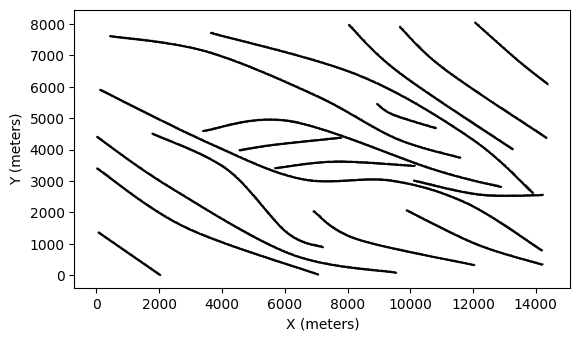

In [153]:
grid_spacing = 15
map_array = create_map(path, grid_spacing)

fig, ax = plot_map(map_array)

fig.show()

In [173]:
def get_values_along_line(image_array, x1, y1, x2, y2):
    """
    Plot a traverse on the map between two coordinates. 
    Return an array of every pixel value in the traverse.
    """

    # Flip line if x2 is smaller than x1
    if x2 < x1:
        x2 = x1

    # Find the grid spacing of the map
    grid_spacing = image_array[2,1,1] - image_array[1,1,1]

    # Create an array of x values between x1 and x2 (inclusive)
    x_range = np.arange(x1, x2+ 1, grid_spacing)  

    print(x_range)

    # Define a function that interpolates values along the line between the coordinates
    interp_func = interp1d([x1, x2], [y1, y2], kind="linear", bounds_error=False, fill_value="extrapolate")
    
    # Evaluate the function at the x coordinates
    y_coords = interp_func(x_range)

    # Convert coords to indices of the map
    x_indices = (x_range / grid_spacing).astype(int)
    y_indices = (y_coords / grid_spacing).astype(int)
    
    # Extract the values along the line from the image array between x1 and x2
    traverse_array = image_array[y_indices, x_indices]    
    # List the pixel values
    pixel_values = traverse_array[:,2]
    
    return pixel_values

In [8]:
def count_fault_crossings(array, block_size):
    """
    Take the one dimensional array of pixel values from the map traverse and sum every non NaN element (corresponding to a fault)
    Discount consecutive non NaN values (duplicate pixel values, only counts as one fault crossing)
    """
    
    count = 0
    i = 0
    while i < len(array):
        block = array[i:i+block_size]
        if np.any(block == 1):
            count += 1
            i += block_size + 1
        else:
            i += block_size
    return count


In [10]:
def traverse_map_at_bearing(map_array, start_point, bearing_degrees, distance_meters):
    # Convert the bearing to radians (subtract from 90 to convert to clockwise from north)
    bearing_radians = math.radians(90 - bearing_degrees)

    # Calculate the end point
    x0, y0 = start_point
    x1 = x0 + distance_meters * math.cos(bearing_radians)
    y1 = y0 + distance_meters * math.sin(bearing_radians)

    # Pack coords into array
    coords = [[x0, y0],[x1,y1]]

    # Get all values along the interpolated line
    values = get_values_along_line(map_array, start_point[0], start_point[1], x1, y1)

    return coords, values
""

[5000.]


/tmp/ipykernel_5117/276280809.py:27: RuntimeWarning: invalid value encountered in cast
  y_indices = (y_coords / grid_spacing).astype(int)


Fault Crossings: 0


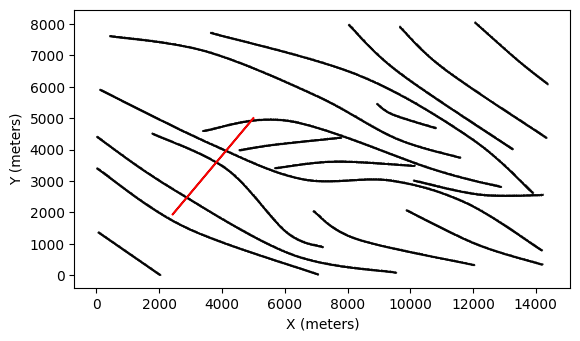

In [175]:
"""
Test Traversal Function
"""

coords, values = traverse_map_at_bearing(map_array, (5000, 5000), 220, 4000)

# Count fault crossings
fault_crossings = count_fault_crossings(values, 4)

fig, ax = plot_map(map_array)

# add traversal to map
x = [coords[0][0], coords[1][0]]
y = [coords[0][1], coords[1][1]]

# Plot the line
plt.plot(x, y, c="red")

# Add an arrow to the line
dx = x[1] - x[0]
dy = y[1] - y[0]
plt.arrow(x[0], y[0], dx, dy, length_includes_head=True, head_width=10)

print(f"Fault Crossings: {fault_crossings}")

In [82]:
def random_map_position(map_array, edge_distance):
    """
    Plot a random position on a map array, with a defined distance from the edges
    """

    # Find the grid spacing of the map
    grid_spacing = map_array[2,1,1] - map_array[1,1,1]

    # Get range of x and y axes
    x_range = np.ptp(map_array[:,:,0])
    y_range = np.ptp(map_array[:,:,1])

    # Truncate the ranges
    x_truncated_range = np.arange(
        edge_distance,
        (x_range - edge_distance),
        grid_spacing,
    )
    y_truncated_range = np.arange(
        edge_distance,
        (y_range - edge_distance),
        grid_spacing,
    )

    # Generate random coordinates within the ranges
    rand_x = np.random.choice(x_truncated_range)
    rand_y = np.random.choice(y_truncated_range)

    return [rand_x, rand_y]


    

In [83]:
random_map_position(map_array, 2000)

[7140.0, 2730.0]

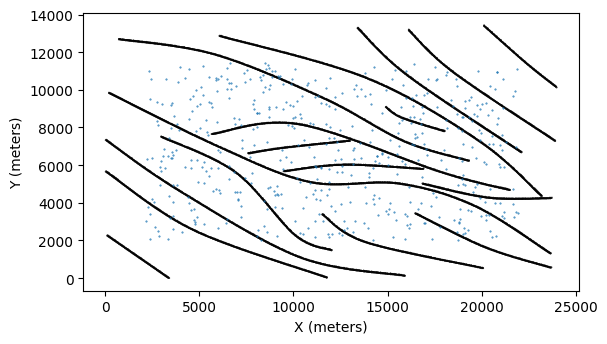

In [89]:
points = []
for i in range(500):
    random_coord = random_map_position(map_array, 2000)

    points.append(random_coord)


plot_map(map_array)

plt.scatter(*zip(*points), s=0.2)


In [132]:
def fault_crossing_simulation(map_array, distance, sims):
    """
    Drop random points on the map, traverse for a defined distance at a random azimuth and count the number of faults crossed
    Aggregate data into a list binned by azimuth
    """

    # Azimuth bins 
    azimuth_bins = range(0, 359, 30)

    # Simulation loop
    data = []
    for i in range(sims):

        # Random starting point within distance buffer
        random_coord = random_map_position(map_array, distance)

        # Plot a traverse from the random coord along a randomly chosen azimuth
        azimuth = np.random.choice(azimuth_bins)
        destination, values = traverse_map_at_bearing(map_array, random_coord, azimuth, distance)

        # Count fault crossings in path
        fault_crossings = count_fault_crossings(values, block_size=5)

        # Calculate fault density (per km)
        fault_density = fault_crossings * 1000 / distance

        # Return an array of the path azimuth, and fault density
        result = [azimuth, fault_crossings, fault_density]

        # Append to data array
        data.append(result)

    return np.array(data)


In [154]:
data = fault_crossing_simulation(map_array, 4000, 5000)

print(data)


/home/nickjdorsch/dev/apps/.conda/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/nickjdorsch/dev/apps/.conda/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo
/tmp/ipykernel_5117/1660378739.py:21: RuntimeWarning: invalid value encountered in cast
  y_indices = (y_coords / grid_spacing).astype(int)


[[150.     2.     0.5 ]
 [330.     0.     0.  ]
 [120.     3.     0.75]
 ...
 [330.     0.     0.  ]
 [ 90.     4.     1.  ]
 [120.     3.     0.75]]


(array([3.071e+03, 6.120e+02, 6.180e+02, 4.200e+02, 1.920e+02, 7.300e+01,
        1.100e+01, 2.000e+00, 0.000e+00, 1.000e+00]),
 array([0.   , 0.275, 0.55 , 0.825, 1.1  , 1.375, 1.65 , 1.925, 2.2  ,
        2.475, 2.75 ]),
 <BarContainer object of 10 artists>)

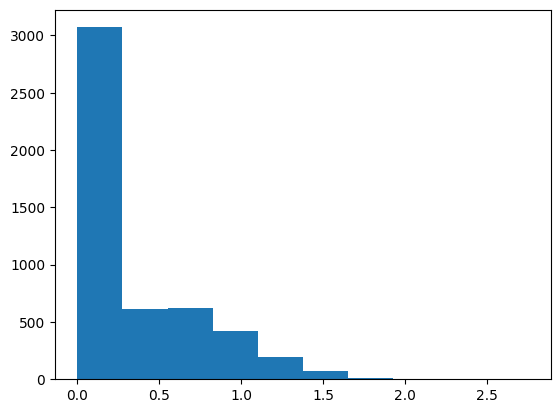

In [161]:
plt.hist(data[:,2])

In [156]:
import pandas as pd

# create a DataFrame
df = pd.DataFrame(data=data, columns=['azimuth', 'fault_encounters', 'fault_density'])

# print the DataFrame
print(df)

      azimuth  fault_encounters  fault_density
0       150.0               2.0           0.50
1       330.0               0.0           0.00
2       120.0               3.0           0.75
3       240.0               0.0           0.00
4         0.0               0.0           0.00
...       ...               ...            ...
4995    180.0               0.0           0.00
4996      0.0               0.0           0.00
4997    330.0               0.0           0.00
4998     90.0               4.0           1.00
4999    120.0               3.0           0.75

[5000 rows x 3 columns]


In [157]:
df_azi = df.groupby("azimuth")

df_azi.describe()

fault_encounters                                                  
                   count      mean       std  min  25%  50%   75%   max   
azimuth                                                                   
0.0                419.0  0.002387  0.048853  0.0  0.0  0.0  0.00   1.0  \
30.0               400.0  2.805000  1.146849  0.0  2.0  3.0  4.00   6.0   
60.0               404.0  4.047030  1.360655  1.0  3.0  4.0  5.00   7.0   
90.0               431.0  2.997680  1.205605  0.0  2.0  3.0  4.00   6.0   
120.0              434.0  3.059908  1.200887  1.0  2.0  3.0  3.75  11.0   
150.0              420.0  2.452381  0.908785  0.0  2.0  2.0  3.00   5.0   
180.0              420.0  0.002381  0.048795  0.0  0.0  0.0  0.00   1.0   
210.0              424.0  0.000000  0.000000  0.0  0.0  0.0  0.00   0.0   
240.0              417.0  0.000000  0.000000  0.0  0.0  0.0  0.00   0.0   
270.0              425.0  0.000000  0.000000  0.0  0.0  0.0  0.00   0.0   
300.0              374.0  0.000000  0.000000  0.0  0.0  0.0  0.00   0.0   
330.0              432.0  0.000000  0.000000  0.0  0.0  0.0  0.00   0.0   

        fault_density                                                      
                count      mean       std   min   25%   50%     75%   max  
azimuth                                                                    
0.0             419.0  0.000597  0.012213  0.00  0.00  0.00  0.0000  0.25  
30.0            400.0  0.701250  0.286712  0.00  0.50  0.75  1.0000  1.50  
60.0            404.0  1.011757  0.340164  0.25  0.75  1.00  1.2500  1.75  
90.0            431.0  0.749420  0.301401  0.00  0.50  0.75  1.0000  1.50  
120.0           434.0  0.764977  0.300222  0.25  0.50  0.75  0.9375  2.75  
150.0           420.0  0.613095  0.227196  0.00  0.50  0.50  0.7500  1.25  
180.0           420.0  0.000595  0.012199  0.00  0.00  0.00  0.0000  0.25  
210.0           424.0  0.000000  0.000000  0.00  0.00  0.00  0.0000  0.00  
240.0           417.0  0.000000  0.000000  0.00  0.00  0.00  0.0000  0.00  
270.0           425.0  0.000000  0.000000  0.00  0.00  0.00  0.0000  0.00  
300.0           374.0  0.000000  0.000000  0.00  0.00  0.00  0.0000  0.00  
330.0           432.0  0.000000  0.000000  0.00  0.00  0.00  0.0000  0.00